# SWMAL Exercise

## Learning Curves

### The Generalization Error, Over- and Underfitting, Early Stopping, and Optimal Capacity

In this exercise, we need to explain all important overall concepts in training. Let's begin with Figure 5.3 from Deep Learning (Ian Goodfellow, et. al. [DL]), which pretty much sums it all up

<img src="https://itundervisning.ase.au.dk/SWMAL/L08/Figs/dl_generalization_error.png" alt="WARNING: could not get image from server." style="height:500px">


### Qa) The Generalization Error

Write a detailed description of figure 5.3 (above) for your hand-in.
 
All concepts in the figure must be explained 

* training/generalization error, 
* underfit/overfit zone, 
* optimal capacity, 
* generalization gab, 
* and the two axes: x/capacity, y/error.

### Qb Learning Curves

Next, produce a loss vs epoch graph ala (from `04_training_linear_models.ipynb` [GITHOML]) 

<img src="https://itundervisning.ase.au.dk/SWMAL/L08/Figs/training_curve.png" alt="WARNING: could not get image from server.">


for your linear regressor, `MyLinReg`, from an earlier lesson. You need a function 

>```LossHistory()```

on your regressor class, that accumulates the internally calculated $J$'s. Once `LossHistory` is ready, plot it using the code below.

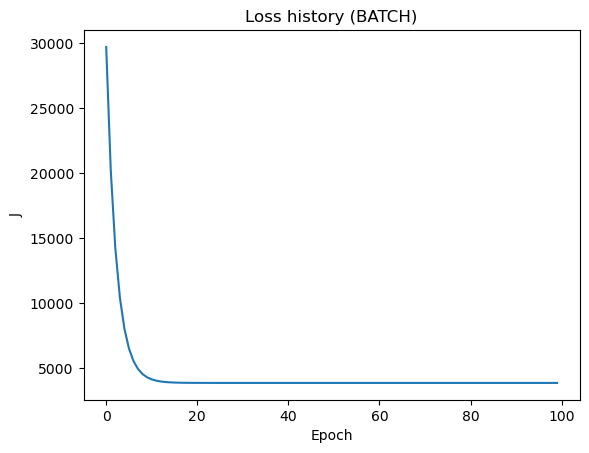

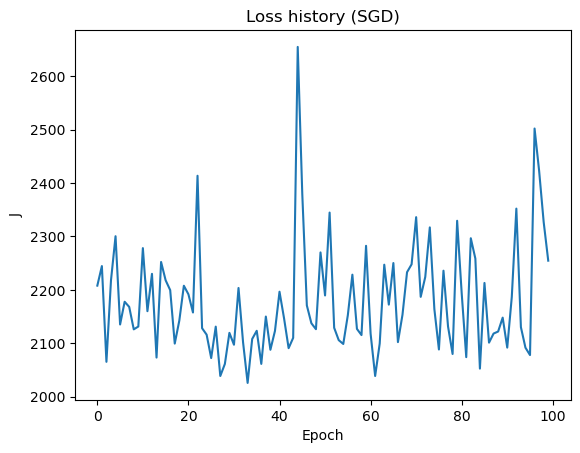

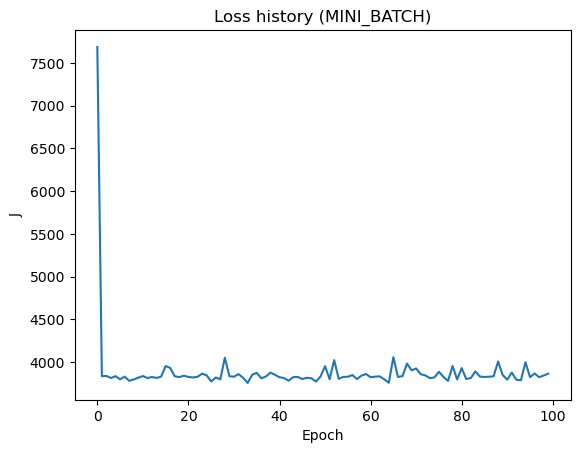

In [5]:
from sklearn.datasets import load_diabetes
from MyLinReg import MyLinReg
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

X, y = load_diabetes(return_X_y=True)
X = X[:, [2]]  # BMI feature

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

methods = ['batch', 'sgd', 'mini_batch']

for method in methods:
    r = MyLinReg(eta0=0.1, max_iter=100)
    r.fit(X_train, y_train, method)
    h = r.LossHistory()

    fig, ax = plt.subplots()
    plt.plot(h)
    ax.set_title(f"Loss history ({method.upper()})")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("J")
    plt.show()


### Qc)  Early Stopping

Then implement ___early stopping___, in your `MyLinReg` estimator. Below is a graphical view of early stopping similar to Figure 4-20 p.162 [HOML] (for a non-linear model?)

<img src="https://itundervisning.ase.au.dk/SWMAL/L08/Figs/early_stopping.png" alt="WARNING: could not get image from server.">

Write an explanation of the early stopping concept in text, implement it in your linear regressor and write some test/demo code, that via some learning-curve graphs demonstrates how it works when training your linear regressor in both _batch-gradient descent_ and 
_stochastic gradient descent_ modes.

Loaded Diabetes dataset: X shape=(442, 10), y shape=(442,)

--- Training Batch GD on Diabetes Data ---
BGD No ES: Ran for 500 iterations.
Early stopping triggered at iteration 65 (Batch GD).
BGD ES: Ran for 65 iterations.
BGD Scores (R2 on full scaled data): No ES=0.5171, ES=0.5121


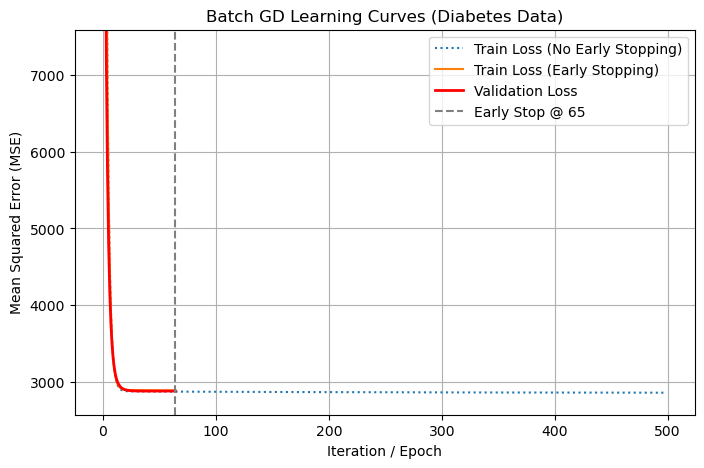


--- Training Stochastic GD on Diabetes Data ---
SGD No ES: Ran for 500 epochs.
Early stopping triggered at epoch 45 (SGD).
SGD ES: Ran for 45 epochs.
SGD Scores (R2 on full scaled data): No ES=0.4343, ES=0.5029


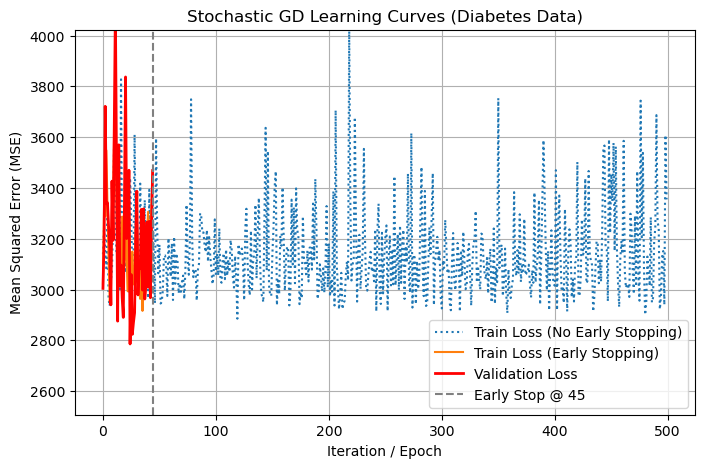


--- Demonstration Complete ---


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_diabetes 
from sklearn.preprocessing import StandardScaler
from MyLinReg import MyLinReg 

np.random.seed(42)

X, y = load_diabetes(return_X_y=True) 

print(f"Loaded Diabetes dataset: X shape={X.shape}, y shape={y.shape}")

y = y.ravel() 

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


max_iterations = 500      
learning_rate = 0.1
sgd_learning_rate = 0.01

es_params = {
    'early_stopping': True,
    'validation_split': 0.2, # Use 20% for validation
    'n_iter_no_change': 20,  # Patience
    'tol': 1e-4
}
no_es_params = {'early_stopping': False}

# --- 3. Plotting Function (No changes needed) ---
def plot_learning_curves(model_no_es, model_es, title):
    """Plots training and validation loss curves."""
    history_no_es = model_no_es.LossHistory()
    history_es = model_es.LossHistory()
    val_history_es = model_es.ValLossHistory()

    # Check if histories are populated (training might fail with bad parameters)
    if not history_no_es and not history_es:
        print(f"Warning: No loss history found for '{title}'. Skipping plot.")
        return
        
    plt.figure(figsize=(8, 5))
    
    if history_no_es:
        plt.plot(history_no_es, label="Train Loss (No Early Stopping)", linewidth=1.5, linestyle=':')
    if history_es:
        plt.plot(history_es, label="Train Loss (Early Stopping)", linewidth=1.5)

    if val_history_es: # Check if validation history exists
        plt.plot(val_history_es, label="Validation Loss", linewidth=2, color='red')
        # Mark where early stopping happened (if it stopped early)
        stopped_iter = len(history_es)
        # Check if model_es exists and has max_iter attribute before comparing
        if hasattr(model_es, 'max_iter') and stopped_iter < model_es.max_iter:
             plt.axvline(stopped_iter - 1, color='grey', linestyle='--',
                         label=f'Early Stop @ {stopped_iter}')

    plt.title(title)
    plt.xlabel('Iteration / Epoch')
    plt.ylabel('Mean Squared Error (MSE)')
    plt.legend()
    plt.grid(True)
    
    # Adjust ylim to focus on convergence, clipping extreme early values if needed
    # Handle potential empty lists
    all_losses = [loss for loss in (history_no_es + history_es + val_history_es) if np.isfinite(loss)]
    if all_losses:
        min_loss = min(all_losses) 
        percentile_loss = np.percentile(all_losses, 98) 
        plt.ylim(bottom=min_loss * 0.9, top=percentile_loss * 1.1 if percentile_loss > min_loss else min_loss * 1.5)
    else:
        plt.ylim(bottom=0) # Default if no valid losses

    plt.show()

# --- 4. Batch Gradient Descent Demo ---
print("\n--- Training Batch GD on Diabetes Data ---")

# Without Early Stopping
model_bgd_no_es = MyLinReg(eta0=learning_rate, max_iter=max_iterations, **no_es_params)
model_bgd_no_es.fit(X_scaled, y, method='batch')
print(f"BGD No ES: Ran for {len(model_bgd_no_es.LossHistory())} iterations.")
# Score on the data it trained on (or split beforehand if true test score needed)
score_bgd_no_es = model_bgd_no_es.score(X_scaled, y) 

# With Early Stopping
model_bgd_es = MyLinReg(eta0=learning_rate, max_iter=max_iterations, **es_params)
model_bgd_es.fit(X_scaled, y, method='batch')
print(f"BGD ES: Ran for {len(model_bgd_es.LossHistory())} iterations.")
score_bgd_es = model_bgd_es.score(X_scaled, y)

print(f"BGD Scores (R2 on full scaled data): No ES={score_bgd_no_es:.4f}, ES={score_bgd_es:.4f}")
plot_learning_curves(model_bgd_no_es, model_bgd_es, 'Batch GD Learning Curves (Diabetes Data)')


# --- 5. Stochastic Gradient Descent Demo ---
print("\n--- Training Stochastic GD on Diabetes Data ---")
# Without Early Stopping
model_sgd_no_es = MyLinReg(eta0=sgd_learning_rate, max_iter=max_iterations, **no_es_params)
model_sgd_no_es.fit(X_scaled, y, method='sgd')
print(f"SGD No ES: Ran for {len(model_sgd_no_es.LossHistory())} epochs.")
score_sgd_no_es = model_sgd_no_es.score(X_scaled, y)

# With Early Stopping
model_sgd_es = MyLinReg(eta0=sgd_learning_rate, max_iter=max_iterations, **es_params)
model_sgd_es.fit(X_scaled, y, method='sgd')
print(f"SGD ES: Ran for {len(model_sgd_es.LossHistory())} epochs.")
score_sgd_es = model_sgd_es.score(X_scaled, y)

print(f"SGD Scores (R2 on full scaled data): No ES={score_sgd_no_es:.4f}, ES={score_sgd_es:.4f}")
plot_learning_curves(model_sgd_no_es, model_sgd_es, 'Stochastic GD Learning Curves (Diabetes Data)')

print("\n--- Demonstration Complete ---")

### Qd:  [OPTIONAL]  Using a Polynomial Regressor to Produce an Error-vs-Capacity Graph

Finally, create a polynomial estimator based on your `MyLinReg`, see details of
how to expend a linear regressor to a polynomial fitting in [HOLM] or in

> https://scikit-learn.org/stable/auto_examples/model_selection/plot_underfitting_overfitting.html
 
that contains most of the code you will need. 
 
With a polynomial regressor, you should be able to reproduce a graph similar to Figure 5.3 from Deep Learning [DL], where you notice that the _x-axis_ is capacity and not _epoch_ as the learning curves you just produced in Qb/c.

In [ ]:
assert False "TODO: implement a polynomial-fit pipeline, and create an Error-vs-Capacity plot..

pipeline = Pipeline([
      ("polynomial_features", polynomial_features),
      ("linear_regression",   MyLinReg())
  ])


### Qe Conclusion

Sum it all up in a nice, well-written conclusion.

REVISIONS||
:-|:-
2018-12-19| CEF, initial.                  
2018-02-14| CEF, major update and put in sync with under/overfitting exe.         
2018-02-20| CEF, fixed revision table malformatting.
2018-02-25| CEF, minor text updates, and made Qc optional.
2018-02-25| CEF, updated code, made more functions.
2018-03-11| CEF, corrected RSME to RMSE.
2019-10-08| CEF, updated to ITMAL E19.
2020-03-14| CEF, updated to ITMAL F20.
2020-10-15| CEF, updated to ITMAL E20.
2020-11-17| CEF, added a comment on 90-degree polynomial, made early stopping a pseudo code exe.
2021-03-22| CEF, changed crossref from "capacity_under_overfitting.ipynb Qc" to Qa+b in QdExplain the Polynomial RMSE-Capacity Plot. 
2021-03-23| CEF, changed 'cv RMSE' legend to 'validation RMSE'.
2021-10-31| CEF, updated to ITMAL E21.
2022-03-25| CEF, updated to SWMAL F22.
2023-03-16| CEF, minor update to SWMAL F23.
2024-09-25| CEF, major update, combined  generalization_error.ipynb and capacity_under_overfitting.ipynb, removed review parts, added graphs plots for MyLinReg.
2024-10-14| CEF, minor text updates.